# XRD Dataset Analysis

Повноцінний аналіз датасету для навчання ML моделі:
- 📊 Pandas-based статистика
- 📈 Візуалізація розподілів параметрів
- 🔗 Кореляційний аналіз
- ⚖️ Uniformity testing (рівномірність для stratified sampling)
- 📉 Візуалізація sample curves
- 🤖 ML Readiness scoring

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Import from model_common.py - single source of truth
from model_common import PARAM_NAMES, RANGES

# Styling
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports successful")
print(f"Parameters: {PARAM_NAMES}")

✅ Imports successful
Parameters: ['Dmax1', 'D01', 'L1', 'Rp1', 'D02', 'L2', 'Rp2']


## Configuration

In [2]:
# Dataset to analyze
DATASET_PATH = "datasets/dataset_959075_dl100_7d.pkl"

# Experimental parameters (for coverage check)
PARAMS_EXPERIMENT = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]
PARAMS_DEFAULT = [0.01305, 0.0017, 5800e-8, 3500e-8, 0.004845, 4000e-8, -500e-8]

print(f"📂 Dataset: {DATASET_PATH}")
print(f"🧪 Experimental params: {PARAMS_EXPERIMENT}")

📂 Dataset: datasets/dataset_959075_dl100_7d.pkl
🧪 Experimental params: [0.008094, 0.000943, 5.2e-05, 3.5e-05, 0.00255, 3e-05, -5e-07]


## 1. Load Dataset

In [3]:
# Load pickle file
with open(DATASET_PATH, "rb") as f:
    data = pickle.load(f)

print("✅ Dataset loaded")
print(f"\nKeys: {list(data.keys())}")
print(f"\nX shape: {data['X'].shape}")
print(f"Y shape: {data['Y'].shape}")

if 'crop_params' in data:
    print("\n✅ New format with crop_params:")
    for k, v in data['crop_params'].items():
        if k != 'note':
            print(f"  {k}: {v}")
else:
    print("\n⚠️  Old format without crop_params")

# Extract arrays
X = data['X']
Y = data['Y']
n_samples = X.shape[0]

print(f"\n📊 Total samples: {n_samples:,}")
print(f"📊 Curve length: {Y.shape[1]}")

✅ Dataset loaded

Keys: ['X', 'Y', 'crop_params', 'generation_params']

X shape: (959075, 7)
Y shape: (959075, 701)

✅ New format with crop_params:
  m1: 701
  start_ML: 50
  cropped_length: 651

📊 Total samples: 959,075
📊 Curve length: 701


## 2. Pandas DataFrame Analysis

In [4]:
# Convert X to pandas DataFrame
df = pd.DataFrame(X, columns=PARAM_NAMES)

# Convert L, Rp to Angstroms for better readability
for col in ['L1', 'Rp1', 'L2', 'Rp2']:
    df[f'{col}_A'] = df[col] * 1e8

print("✅ Created DataFrame")
print(f"Shape: {df.shape}")
df.head()

✅ Created DataFrame
Shape: (959075, 11)


,Dmax1,D01,L1,Rp1,D02,L2,Rp2,L1_A,Rp1_A,L2_A,Rp2_A
0,0.0060,0.0005,0.000025,1.550000e-05,0.0010,0.000015,-0.000065,2500.0,1550.0,1500.0,-6500.0
1,0.0035,0.0005,0.000020,1.550000e-05,0.0060,0.000010,-0.000060,2000.0,1550.0,1000.0,-6000.0
2,0.0060,0.0030,0.000025,5.000000e-07,0.0010,0.000015,-0.000055,2500.0,50.0,1500.0,-5500.0
3,0.0060,0.0030,0.000015,5.000000e-07,0.0035,0.000010,-0.000060,1500.0,50.0,1000.0,-6000.0
4,0.0085,0.0080,0.000015,5.000000e-07,0.0060,0.000015,-0.000045,1500.0,50.0,1500.0,-4500.0


In [5]:
# Full statistical summary
print("="*80)
print("📊 PANDAS DESCRIBE - FULL STATISTICS")
print("="*80)
df[PARAM_NAMES].describe()

📊 PANDAS DESCRIBE - FULL STATISTICS


,Dmax1,D01,L1,Rp1,D02,L2,Rp2
count,959075.000000,959075.000000,959075.000000,9.590750e+05,959075.000000,959075.000000,9.590750e+05
mean,0.017958,0.007559,0.000046,2.258889e-05,0.012109,0.000024,-3.250240e-05
std,0.008492,0.006480,0.000015,1.392189e-05,0.007849,0.000013,1.957018e-05
min,0.001000,0.000500,0.000005,5.000000e-07,0.001000,0.000005,-6.500000e-05
25%,0.011000,0.003000,0.000035,1.050000e-05,0.006000,0.000015,-5.000000e-05
50%,0.018500,0.005500,0.000045,2.050000e-05,0.011000,0.000025,-3.000000e-05
75%,0.026000,0.010500,0.000060,3.550000e-05,0.018500,0.000035,-1.500000e-05
max,0.031000,0.028000,0.000070,5.050000e-05,0.028500,0.000050,9.094947e-21


In [6]:
# Check for data quality issues
print("="*80)
print("🔍 DATA QUALITY CHECKS")
print("="*80)

# Check for NaN
nan_count = df[PARAM_NAMES].isna().sum().sum()
print(f"\n❌ NaN values: {nan_count}")
if nan_count > 0:
    print("   WARNING: Dataset contains NaN values!")
else:
    print("   ✅ No NaN values")

# Check for inf
inf_count = np.isinf(X).sum()
print(f"\n❌ Inf values: {inf_count}")
if inf_count > 0:
    print("   WARNING: Dataset contains Inf values!")
else:
    print("   ✅ No Inf values")

# Check for duplicates
duplicate_count = df[PARAM_NAMES].duplicated().sum()
print(f"\n🔄 Duplicate rows: {duplicate_count} ({100*duplicate_count/n_samples:.2f}%)")
if duplicate_count > n_samples * 0.01:  # >1%
    print("   ⚠️  High number of duplicates - may indicate sampling issues")
else:
    print("   ✅ Acceptable duplicate rate")

# Check unique values per parameter
print("\n🔢 Unique values per parameter:")
for col in PARAM_NAMES:
    unique = df[col].nunique()
    print(f"   {col:8s}: {unique:6d} unique values")

🔍 DATA QUALITY CHECKS

❌ NaN values: 0
   ✅ No NaN values

❌ Inf values: 0
   ✅ No Inf values

🔄 Duplicate rows: 0 (0.00%)
   ✅ Acceptable duplicate rate

🔢 Unique values per parameter:
   Dmax1   :     13 unique values
   D01     :     12 unique values
   L1      :     14 unique values
   Rp1     :     11 unique values
   D02     :     12 unique values
   L2      :     10 unique values
   Rp2     :     14 unique values


## 3. Compare with RANGES (model_common.py)

In [7]:
print("="*80)
print("⚖️  COMPARISON WITH RANGES (model_common.py)")
print("="*80)

comparison_data = []
all_match = True

for col in PARAM_NAMES:
    actual_min = df[col].min()
    actual_max = df[col].max()
    expected_min, expected_max = RANGES[col]
    
    # Check match
    tol = 1e-9
    min_match = abs(actual_min - expected_min) < tol
    max_match = abs(actual_max - expected_max) < tol
    matches = min_match and max_match
    
    if not matches:
        all_match = False
    
    # For display
    if col in ['L1', 'Rp1', 'L2', 'Rp2']:
        comparison_data.append({
            'Parameter': col,
            'Dataset Min': f"{actual_min*1e8:.1f} Å",
            'Dataset Max': f"{actual_max*1e8:.1f} Å",
            'RANGES Min': f"{expected_min*1e8:.1f} Å",
            'RANGES Max': f"{expected_max*1e8:.1f} Å",
            'Match': '✅' if matches else '❌'
        })
    else:
        comparison_data.append({
            'Parameter': col,
            'Dataset Min': f"{actual_min:.6f}",
            'Dataset Max': f"{actual_max:.6f}",
            'RANGES Min': f"{expected_min:.6f}",
            'RANGES Max': f"{expected_max:.6f}",
            'Match': '✅' if matches else '❌'
        })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print("\n" + "="*80)
if all_match:
    print("✅ ALL PARAMETERS MATCH RANGES - Dataset is synchronized with model_common.py")
else:
    print("❌ MISMATCH DETECTED - Dataset does not match RANGES in model_common.py")
print("="*80)

⚖️  COMPARISON WITH RANGES (model_common.py)
Parameter Dataset Min Dataset Max RANGES Min RANGES Max Match
    Dmax1    0.001000    0.031000   0.001000   0.031000     ✅
      D01    0.000500    0.028000   0.000500   0.030500     ❌
       L1     500.0 Å    7000.0 Å    500.0 Å   7000.0 Å     ✅
      Rp1      50.0 Å    5050.0 Å     50.0 Å   5050.0 Å     ✅
      D02    0.001000    0.028500   0.001000   0.031000     ❌
       L2     500.0 Å    5000.0 Å    500.0 Å   5000.0 Å     ✅
      Rp2   -6500.0 Å       0.0 Å  -6500.0 Å      0.0 Å     ✅

❌ MISMATCH DETECTED - Dataset does not match RANGES in model_common.py


## 4. Experimental Data Coverage

In [8]:
print("="*80)
print("🧪 EXPERIMENTAL DATA COVERAGE")
print("="*80)

def check_coverage(params, label):
    print(f"\n{label}:")
    coverage_data = []
    all_covered = True
    
    for param_name, param_val in zip(PARAM_NAMES, params):
        min_val = df[param_name].min()
        max_val = df[param_name].max()
        covered = min_val <= param_val <= max_val
        
        if not covered:
            all_covered = False
        
        if param_name in ['L1', 'Rp1', 'L2', 'Rp2']:
            coverage_data.append({
                'Param': param_name,
                'Value': f"{param_val*1e8:.1f} Å",
                'Dataset Range': f"[{min_val*1e8:.1f}, {max_val*1e8:.1f}] Å",
                'Covered': '✅' if covered else '❌'
            })
        else:
            coverage_data.append({
                'Param': param_name,
                'Value': f"{param_val:.6f}",
                'Dataset Range': f"[{min_val:.6f}, {max_val:.6f}]",
                'Covered': '✅' if covered else '❌'
            })
    
    df_cov = pd.DataFrame(coverage_data)
    print(df_cov.to_string(index=False))
    
    return all_covered

exp_covered = check_coverage(PARAMS_EXPERIMENT, "📋 Experiment")
def_covered = check_coverage(PARAMS_DEFAULT, "📋 Default")

print("\n" + "="*80)
if exp_covered and def_covered:
    print("✅ ALL EXPERIMENTAL DATA COVERED - Ready for inference")
else:
    print("❌ EXPERIMENTAL DATA NOT FULLY COVERED - Need to expand RANGES")
print("="*80)

🧪 EXPERIMENTAL DATA COVERAGE

📋 Experiment:
Param    Value        Dataset Range Covered
Dmax1 0.008094 [0.001000, 0.031000]       ✅
  D01 0.000943 [0.000500, 0.028000]       ✅
   L1 5200.0 Å    [500.0, 7000.0] Å       ✅
  Rp1 3500.0 Å     [50.0, 5050.0] Å       ✅
  D02 0.002550 [0.001000, 0.028500]       ✅
   L2 3000.0 Å    [500.0, 5000.0] Å       ✅
  Rp2  -50.0 Å     [-6500.0, 0.0] Å       ✅

📋 Default:
Param    Value        Dataset Range Covered
Dmax1 0.013050 [0.001000, 0.031000]       ✅
  D01 0.001700 [0.000500, 0.028000]       ✅
   L1 5800.0 Å    [500.0, 7000.0] Å       ✅
  Rp1 3500.0 Å     [50.0, 5050.0] Å       ✅
  D02 0.004845 [0.001000, 0.028500]       ✅
   L2 4000.0 Å    [500.0, 5000.0] Å       ✅
  Rp2 -500.0 Å     [-6500.0, 0.0] Å       ✅

✅ ALL EXPERIMENTAL DATA COVERED - Ready for inference


## 5. Distribution Analysis

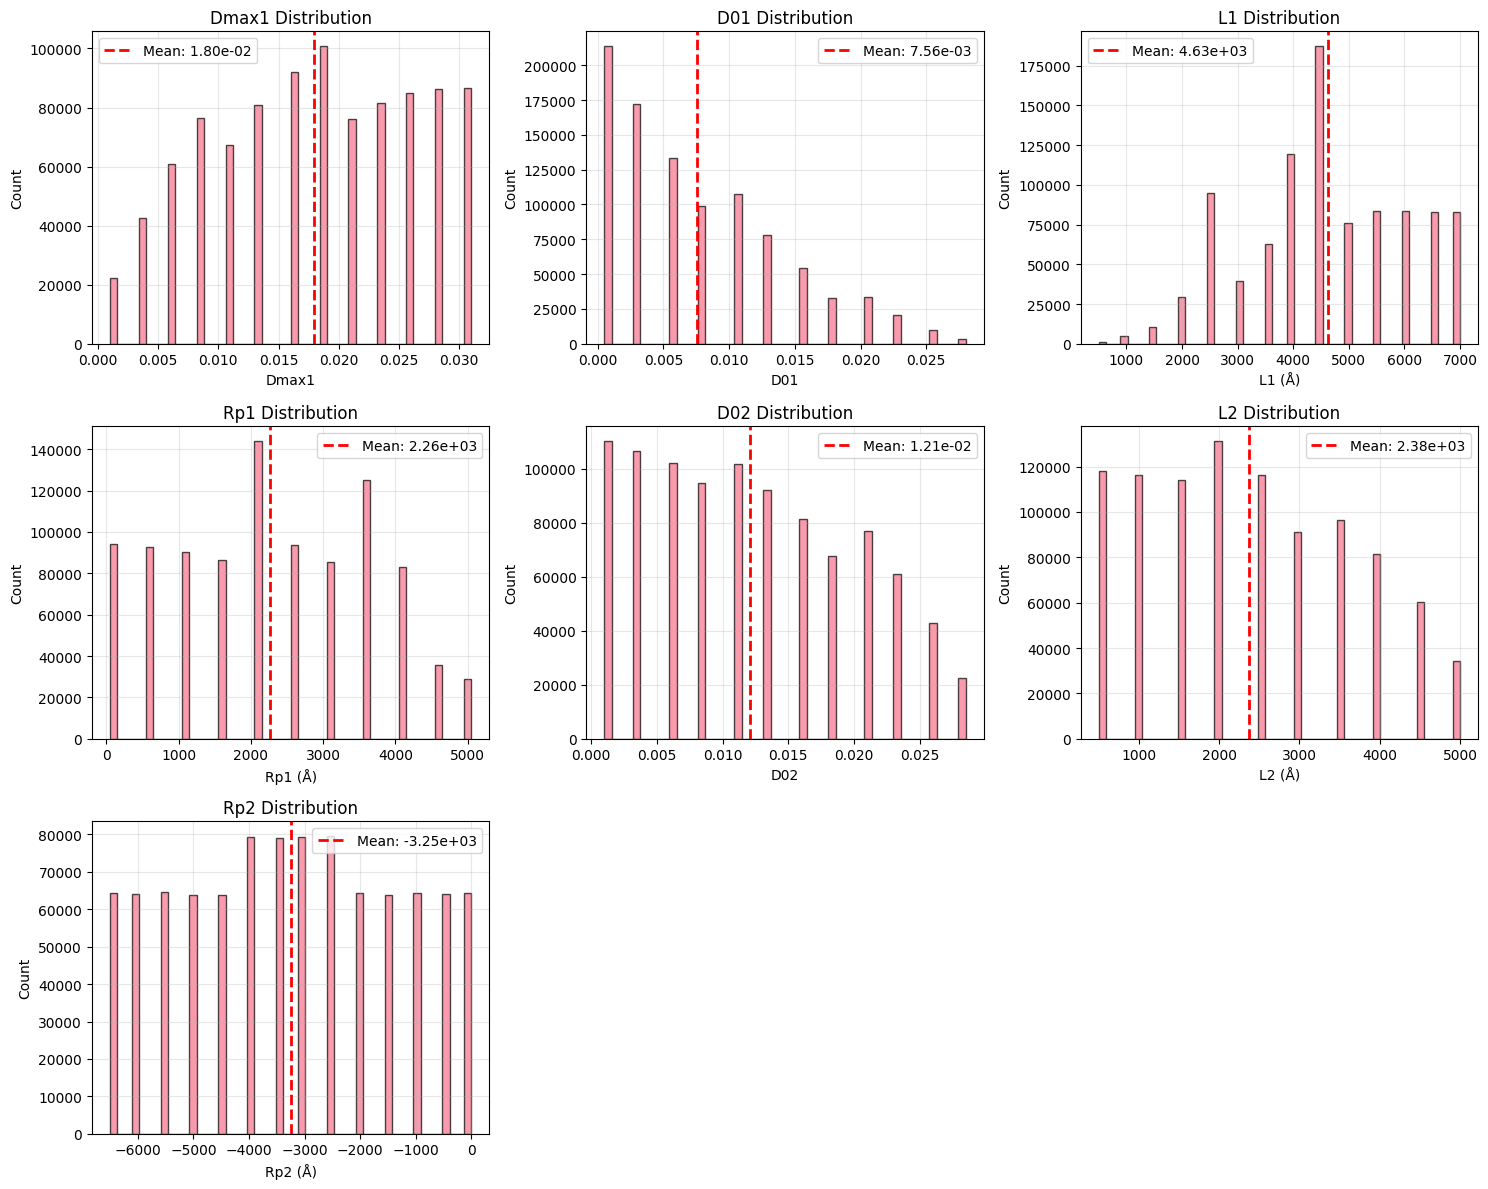

✅ Saved histograms to analysis_reports/distributions_histograms.png


In [ ]:
# Plot histograms for all parameters
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(PARAM_NAMES):
    ax = axes[i]
    
    # Use Angstrom units for L, Rp
    if col in ['L1', 'Rp1', 'L2', 'Rp2']:
        data_plot = df[col] * 1e8
        unit = ' (Å)'
    else:
        data_plot = df[col]
        unit = ''
    
    # Histogram
    ax.hist(data_plot, bins=50, alpha=0.7, edgecolor='black')
    
    # Statistics
    mean_val = data_plot.mean()
    std_val = data_plot.std()
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2e}')
    ax.set_xlabel(f'{col}{unit}')
    ax.set_ylabel('Count')
    ax.set_title(f'{col} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(PARAM_NAMES), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('analysis_report/distributions_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved histograms to analysis_report/distributions_histograms.png")

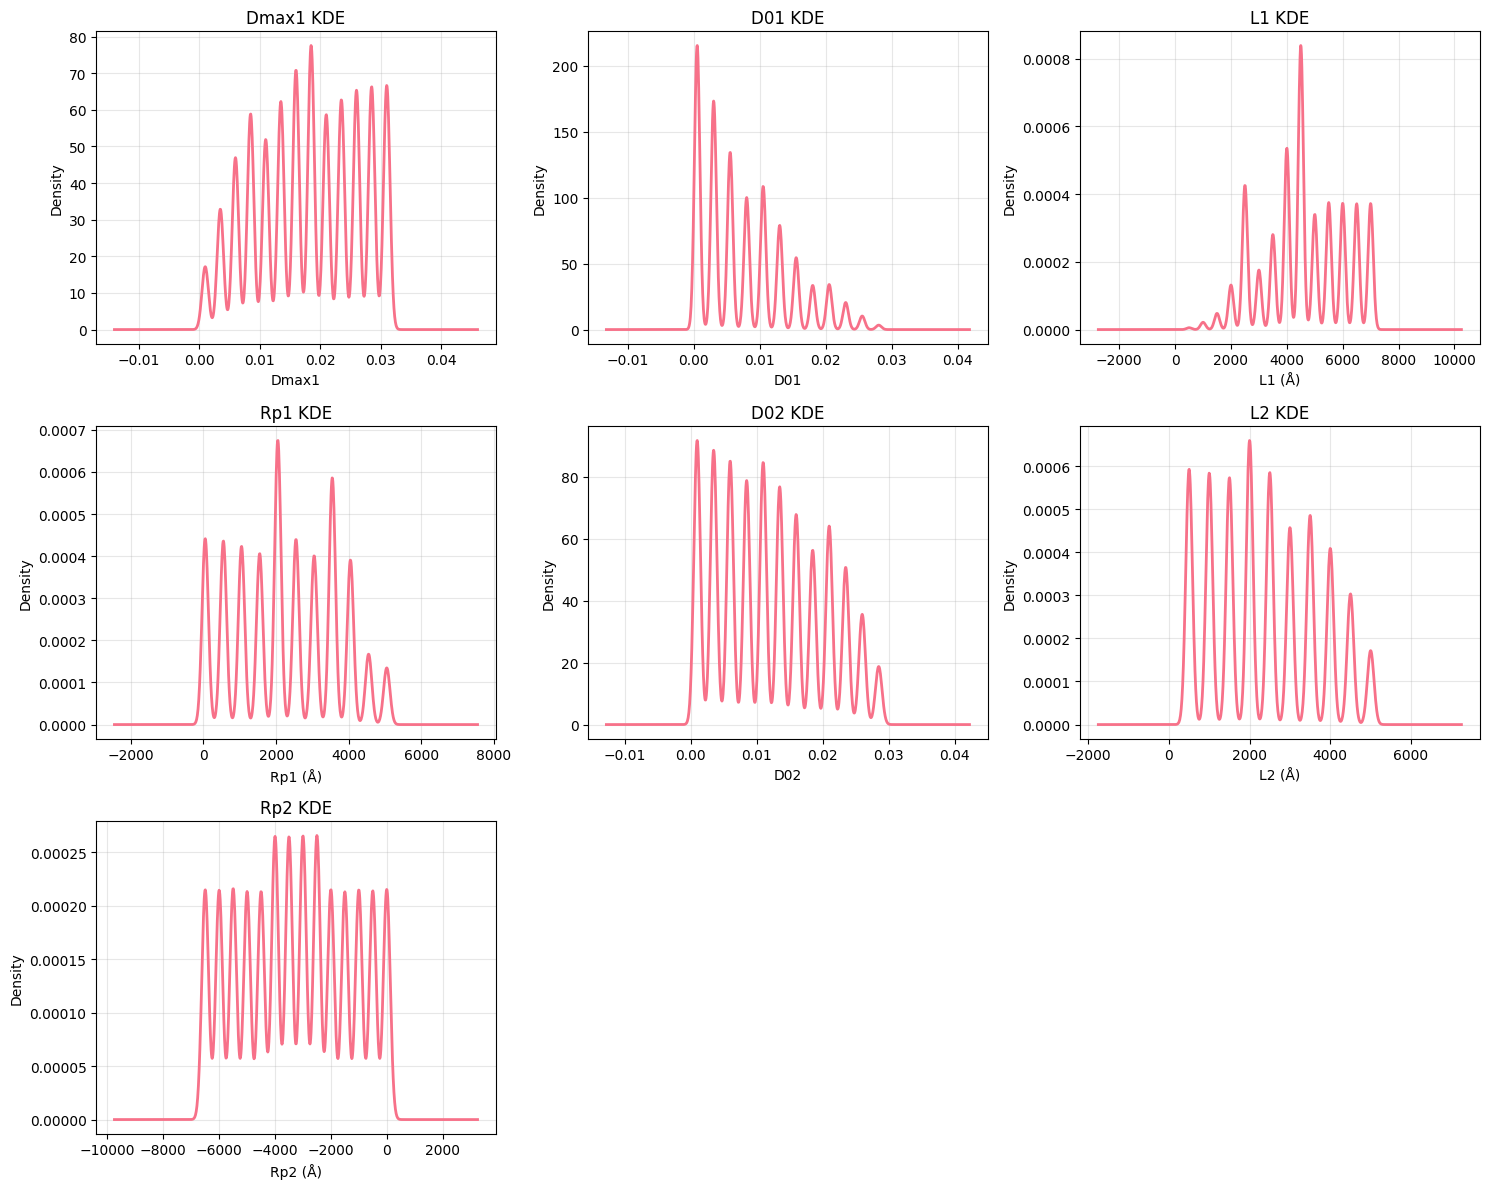

✅ Saved KDE plots to analysis_reports/distributions_kde.png


In [ ]:
# KDE plots (Kernel Density Estimation)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(PARAM_NAMES):
    ax = axes[i]
    
    if col in ['L1', 'Rp1', 'L2', 'Rp2']:
        data_plot = df[col] * 1e8
        unit = ' (Å)'
    else:
        data_plot = df[col]
        unit = ''
    
    # KDE plot
    data_plot.plot(kind='kde', ax=ax, linewidth=2)
    ax.set_xlabel(f'{col}{unit}')
    ax.set_ylabel('Density')
    ax.set_title(f'{col} KDE')
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(PARAM_NAMES), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('analysis_report/distributions_kde.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved KDE plots to analysis_report/distributions_kde.png")

## 6. Uniformity Testing

Для stratified sampling критично важливо мати рівномірний розподіл параметрів.  
Використовуємо **Chi-Square Goodness of Fit Test** для перевірки uniformity.

In [11]:
print("="*80)
print("⚖️  UNIFORMITY TESTING (Chi-Square Test)")
print("="*80)
print("\nNull hypothesis: Distribution is uniform")
print("If p-value > 0.05: Accept (uniform) ✅")
print("If p-value < 0.05: Reject (non-uniform) ❌\n")

uniformity_results = []

for col in PARAM_NAMES:
    # Create bins and observed frequencies
    n_bins = 20
    observed, bin_edges = np.histogram(df[col], bins=n_bins)
    
    # Expected frequency (uniform)
    expected = np.full(n_bins, n_samples / n_bins)
    
    # Chi-square test
    chi2_stat, p_value = stats.chisquare(observed, expected)
    
    # Interpret
    is_uniform = p_value > 0.05
    
    uniformity_results.append({
        'Parameter': col,
        'Chi-Square': f"{chi2_stat:.2f}",
        'p-value': f"{p_value:.4f}",
        'Uniform?': '✅ Yes' if is_uniform else '❌ No',
    })

df_uniformity = pd.DataFrame(uniformity_results)
print(df_uniformity.to_string(index=False))

# Overall verdict
n_uniform = sum(1 for r in uniformity_results if '✅' in r['Uniform?'])
print("\n" + "="*80)
print(f"Uniform parameters: {n_uniform}/{len(PARAM_NAMES)}")
if n_uniform == len(PARAM_NAMES):
    print("✅ ALL DISTRIBUTIONS UNIFORM - Excellent for stratified sampling!")
elif n_uniform >= len(PARAM_NAMES) * 0.8:
    print("⚠️  MOSTLY UNIFORM - Acceptable for training")
else:
    print("❌ NON-UNIFORM - May cause training bias!")
print("="*80)

⚖️  UNIFORMITY TESTING (Chi-Square Test)

Null hypothesis: Distribution is uniform
If p-value > 0.05: Accept (uniform) ✅
If p-value < 0.05: Reject (non-uniform) ❌

Parameter Chi-Square p-value Uniform?
    Dmax1  630010.77  0.0000     ❌ No
      D01 1673255.40  0.0000     ❌ No
       L1 1093138.89  0.0000     ❌ No
      Rp1 1011296.56  0.0000     ❌ No
      D02  809218.09  0.0000     ❌ No
       L2 1130081.61  0.0000     ❌ No
      Rp2  424741.48  0.0000     ❌ No

Uniform parameters: 0/7
❌ NON-UNIFORM - May cause training bias!


## 7. Correlation Analysis

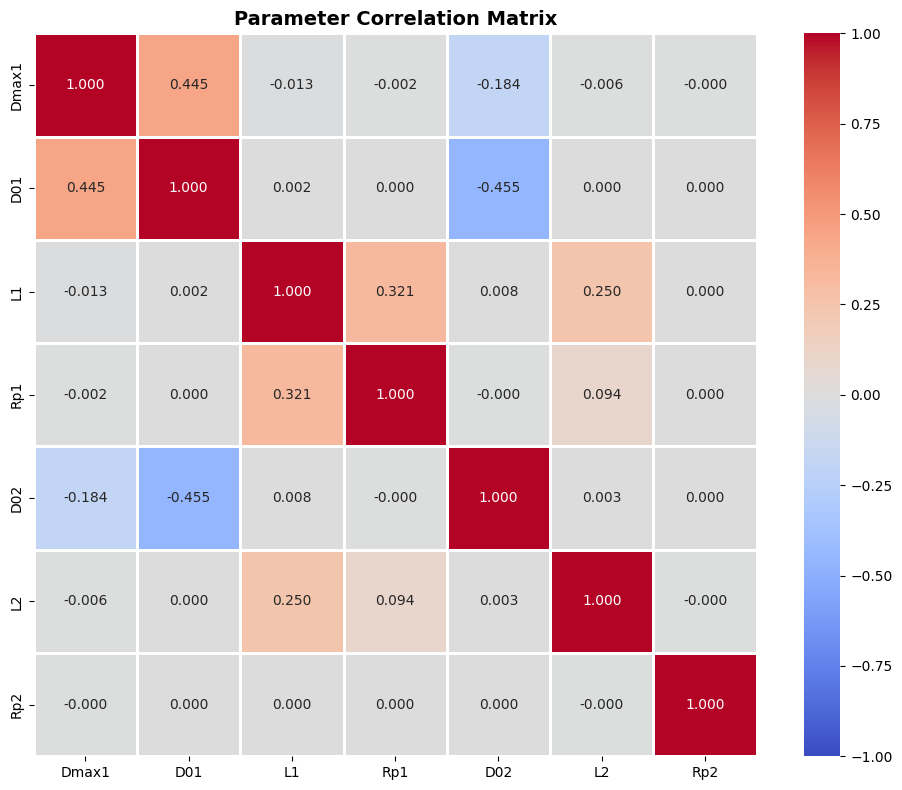

✅ Saved correlation heatmap to analysis_reports/correlation_heatmap.png

🔗 HIGH CORRELATIONS (|r| > 0.7)
✅ No high correlations - parameters are independent


In [ ]:
# Compute correlation matrix
corr_matrix = df[PARAM_NAMES].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=1)
plt.title('Parameter Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('analysis_report/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved correlation heatmap to analysis_report/correlation_heatmap.png")

# Check for high correlations
print("\n" + "="*80)
print("🔗 HIGH CORRELATIONS (|r| > 0.7)")
print("="*80)

high_corr = []
for i in range(len(PARAM_NAMES)):
    for j in range(i+1, len(PARAM_NAMES)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.7:
            high_corr.append({
                'Param 1': PARAM_NAMES[i],
                'Param 2': PARAM_NAMES[j],
                'Correlation': f"{r:.3f}"
            })

if high_corr:
    df_high_corr = pd.DataFrame(high_corr)
    print(df_high_corr.to_string(index=False))
    print("\n⚠️  High correlations detected - may indicate parameter dependencies")
else:
    print("✅ No high correlations - parameters are independent")

## 8. Sample Curves Visualization

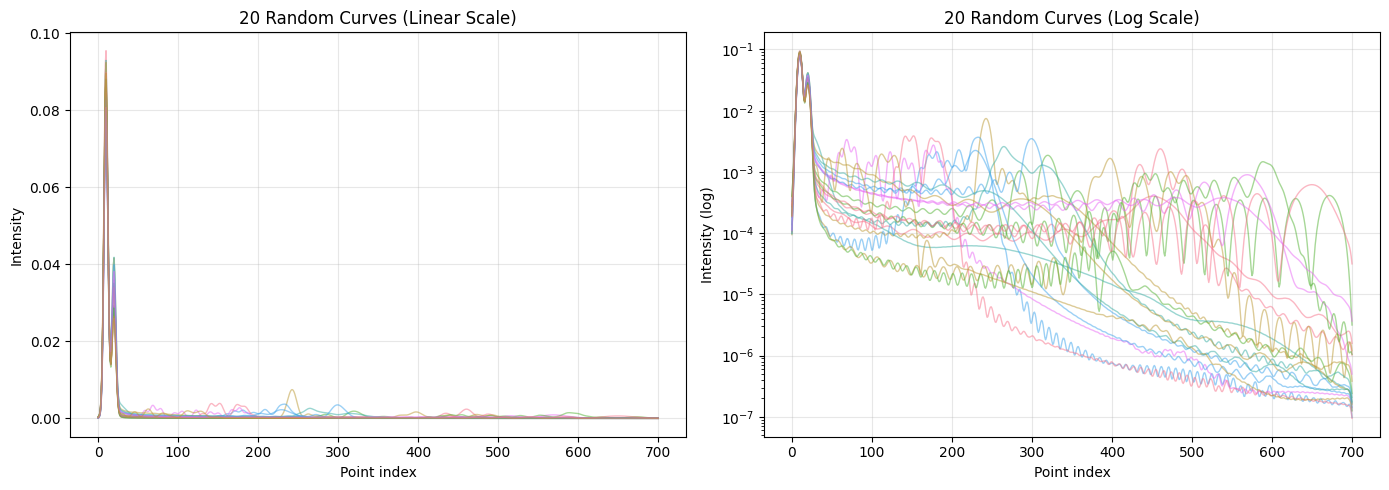

✅ Saved sample curves to analysis_reports/sample_curves.png

🔍 CURVE QUALITY CHECKS

❌ All-zero curves: 0
   ✅ No all-zero curves

❌ Curves with NaN: 0
❌ Curves with Inf: 0
   ✅ All curves valid

📊 Intensity statistics:
   Min: 1.1548e-09
   Max: 1.0175e-01
   Mean: 1.3083e-03
   Std: 7.1814e-03


In [ ]:
# Plot random sample curves
n_samples_plot = 20
random_indices = np.random.choice(n_samples, n_samples_plot, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax = axes[0]
for idx in random_indices:
    ax.plot(Y[idx], alpha=0.5, linewidth=1)
ax.set_xlabel('Point index')
ax.set_ylabel('Intensity')
ax.set_title(f'{n_samples_plot} Random Curves (Linear Scale)')
ax.grid(True, alpha=0.3)

# Log scale
ax = axes[1]
for idx in random_indices:
    ax.semilogy(Y[idx], alpha=0.5, linewidth=1)
ax.set_xlabel('Point index')
ax.set_ylabel('Intensity (log)')
ax.set_title(f'{n_samples_plot} Random Curves (Log Scale)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_report/sample_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved sample curves to analysis_report/sample_curves.png")

# Check for anomalies
print("\n" + "="*80)
print("🔍 CURVE QUALITY CHECKS")
print("="*80)

# Check for all-zero curves
zero_curves = np.all(Y == 0, axis=1).sum()
print(f"\n❌ All-zero curves: {zero_curves}")
if zero_curves > 0:
    print("   WARNING: Some curves are all zeros!")
else:
    print("   ✅ No all-zero curves")

# Check for NaN/Inf in curves
nan_curves = np.any(np.isnan(Y), axis=1).sum()
inf_curves = np.any(np.isinf(Y), axis=1).sum()
print(f"\n❌ Curves with NaN: {nan_curves}")
print(f"❌ Curves with Inf: {inf_curves}")
if nan_curves > 0 or inf_curves > 0:
    print("   WARNING: Some curves contain invalid values!")
else:
    print("   ✅ All curves valid")

# Intensity statistics
print(f"\n📊 Intensity statistics:")
print(f"   Min: {Y.min():.4e}")
print(f"   Max: {Y.max():.4e}")
print(f"   Mean: {Y.mean():.4e}")
print(f"   Std: {Y.std():.4e}")

## 9. ML Readiness Scoring

In [14]:
print("="*80)
print("🤖 ML READINESS EVALUATION")
print("="*80)

score = 0
max_score = 7
checks = []

# 1. Dataset size
size_ok = n_samples >= 10000
if size_ok:
    score += 1
    checks.append(f"✅ Dataset size: {n_samples:,} >= 10K")
else:
    checks.append(f"❌ Dataset size: {n_samples:,} < 10K (too small)")

# 2. RANGES match
if all_match:
    score += 1
    checks.append("✅ RANGES synchronized with model_common.py")
else:
    checks.append("❌ RANGES mismatch with model_common.py")

# 3. Experimental coverage
if exp_covered:
    score += 1
    checks.append("✅ Experimental data covered")
else:
    checks.append("❌ Experimental data NOT covered")

# 4. No quality issues
quality_ok = (nan_count == 0 and inf_count == 0 and zero_curves == 0 and 
              nan_curves == 0 and inf_curves == 0)
if quality_ok:
    score += 1
    checks.append("✅ No data quality issues (NaN, Inf, zeros)")
else:
    checks.append("❌ Data quality issues detected")

# 5. Uniform distribution
if n_uniform >= len(PARAM_NAMES) * 0.8:
    score += 1
    checks.append(f"✅ Uniform distribution ({n_uniform}/{len(PARAM_NAMES)} params)")
else:
    checks.append(f"❌ Non-uniform distribution ({n_uniform}/{len(PARAM_NAMES)} params)")

# 6. Low correlation
low_corr = len(high_corr) == 0
if low_corr:
    score += 1
    checks.append("✅ Parameters independent (low correlation)")
else:
    checks.append(f"⚠️  High correlations detected ({len(high_corr)} pairs)")

# 7. New format
new_format = 'crop_params' in data
if new_format:
    score += 1
    checks.append("✅ New format with crop_params")
else:
    checks.append("⚠️  Old format (no crop_params)")

# Print results
print("\n📋 Checklist:")
for check in checks:
    print(f"   {check}")

print("\n" + "="*80)
print(f"📊 FINAL SCORE: {score}/{max_score}")
print("="*80)

# Verdict
if score == max_score:
    verdict = "🎉 EXCELLENT - Dataset is fully ready for training!"
    recommendation = "✅ Proceed with model training"
elif score >= max_score * 0.7:
    verdict = "✅ GOOD - Dataset is ready with minor issues"
    recommendation = "⚠️  Can train but address warnings for best results"
elif score >= max_score * 0.5:
    verdict = "⚠️  ACCEPTABLE - Dataset has significant issues"
    recommendation = "❌ Fix critical issues before training"
else:
    verdict = "❌ POOR - Dataset not ready"
    recommendation = "🔧 Regenerate dataset with correct parameters"

print(f"\n{verdict}")
print(f"\n💡 Recommendation: {recommendation}")

🤖 ML READINESS EVALUATION

📋 Checklist:
   ✅ Dataset size: 959,075 >= 10K
   ❌ RANGES mismatch with model_common.py
   ✅ Experimental data covered
   ✅ No data quality issues (NaN, Inf, zeros)
   ❌ Non-uniform distribution (0/7 params)
   ✅ Parameters independent (low correlation)
   ✅ New format with crop_params

📊 FINAL SCORE: 5/7

✅ GOOD - Dataset is ready with minor issues

💡 Recommendation: ⚠️  Can train but address warnings for best results


## 10. Summary Report

In [ ]:
print("="*80)
print("📄 DATASET ANALYSIS SUMMARY")
print("="*80)

file_size_mb = Path(DATASET_PATH).stat().st_size / (1024**2)

summary = f"""
📂 Dataset: {DATASET_PATH}
📊 Size: {file_size_mb:.1f} MB
🔢 Samples: {n_samples:,}
📏 Parameters: {len(PARAM_NAMES)}
📉 Curve length: {Y.shape[1]}

✅ RANGES Match: {all_match}
✅ Experimental Coverage: {exp_covered and def_covered}
✅ Data Quality: {quality_ok}
✅ Uniform Distribution: {n_uniform}/{len(PARAM_NAMES)}
✅ Low Correlation: {low_corr}

🎯 ML Readiness Score: {score}/{max_score}
💡 Verdict: {verdict}
📌 Recommendation: {recommendation}

📊 Generated visualizations:
   • analysis_report/distributions_histograms.png
   • analysis_report/distributions_kde.png
   • analysis_report/correlation_heatmap.png
   • analysis_report/sample_curves.png
"""

print(summary)

# Save summary to file
Path('analysis_report').mkdir(exist_ok=True)
summary_file = f"analysis_report/{Path(DATASET_PATH).stem}_summary.txt"
with open(summary_file, 'w') as f:
    f.write(summary)

print(f"\n✅ Summary saved to {summary_file}")
print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)

📄 DATASET ANALYSIS SUMMARY

📂 Dataset: datasets/dataset_959075_dl100_7d.pkl
📊 Size: 2590.3 MB
🔢 Samples: 959,075
📏 Parameters: 7
📉 Curve length: 701

✅ RANGES Match: False
✅ Experimental Coverage: True
✅ Data Quality: True
✅ Uniform Distribution: 0/7
✅ Low Correlation: True

🎯 ML Readiness Score: 5/7
💡 Verdict: ✅ GOOD - Dataset is ready with minor issues
📌 Recommendation: ⚠️  Can train but address warnings for best results

📊 Generated visualizations:
   • analysis_reports/distributions_histograms.png
   • analysis_reports/distributions_kde.png
   • analysis_reports/correlation_heatmap.png
   • analysis_reports/sample_curves.png


✅ Summary saved to analysis_reports/dataset_959075_dl100_7d_summary.txt

✅ ANALYSIS COMPLETE
